In [1]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Dependability

### Session 1

#### Reconstruct Parameters

In [2]:
from numba import njit

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

@njit
def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal.'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

def diag_pre_multiply(vec, mat):
    return np.diag(vec) @ mat

## Extract parameters.
StanDict = dict()
with h5py.File('stan_results/dependability_m1_t1.hdf5', 'r') as f:
    for k, v in f.items():
        if v.ndim: StanDict[k] = v[:]
        else: StanDict[k] = v[()]
            
## Reconstruct parameter covariance matrix (means).
L_c = StanDict['L_c']
sigma_c_pr = StanDict['sigma_c_pr']
Omega_c = np.array([L @ L.T for L in L_c])
Sigma_c = np.array([diag_pre_multiply( np.exp(sigma), L ) @ diag_pre_multiply( np.exp(sigma), L ).T
                    for sigma, L in zip(sigma_c_pr, L_c)])

## Reconstruct parameter covariance matrix (offsets).
L_d = StanDict['L_d']
sigma_d_pr = StanDict['sigma_d_pr']
Omega_d = np.array([L @ L.T for L in L_d])
Sigma_d = np.array([diag_pre_multiply( np.exp(sigma), L ) @ diag_pre_multiply( np.exp(sigma), L ).T
                    for sigma, L in zip(sigma_d_pr, L_d)])

## Reconstruct subject-level parameters (pre-transform).
theta_c = np.array([Sigma @ theta for Sigma, theta in zip(Sigma_c, StanDict['theta_c_pr'])])
theta_d = np.array([Sigma @ theta for Sigma, theta in zip(Sigma_d, StanDict['theta_d_pr'])])
n_samp, n_par, n_sub = theta_c.shape

## Reconstruct subject-level parameters.
mu_pr = StanDict['mu_pr']

beta = np.zeros((n_samp,2,n_sub))
beta[:,0] = 10 * (mu_pr[:,0,0][:,np.newaxis] + theta_c[:,0] - theta_d[:,0])
beta[:,1] = 10 * (mu_pr[:,0,1][:,np.newaxis] + theta_c[:,0] + theta_d[:,0])
beta_mu = 10 * mu_pr[:,0]

eta = np.zeros((n_samp,2,n_sub))
eta[:,0] = phi_approx(mu_pr[:,1,0][:,np.newaxis] + theta_c[:,1] - theta_d[:,1])
eta[:,1] = phi_approx(mu_pr[:,1,1][:,np.newaxis] + theta_c[:,1] + theta_d[:,1])
eta_mu = phi_approx(mu_pr[:,1])

tau = np.zeros((n_samp,2,n_sub))
tau[:,0] = mu_pr[:,2,0][:,np.newaxis] + theta_c[:,2] - theta_d[:,2]
tau[:,1] = mu_pr[:,2,1][:,np.newaxis] + theta_c[:,2] + theta_d[:,2]
tau_mu = mu_pr[:,2]

nu = np.zeros((n_samp,2,n_sub))
nu[:,0] = mu_pr[:,3,0][:,np.newaxis] + theta_c[:,3] - theta_d[:,3]
nu[:,1] = mu_pr[:,3,1][:,np.newaxis] + theta_c[:,3] + theta_d[:,3]
nu_mu = mu_pr[:,3]

#### Posterior predictive check

In [3]:
np.random.seed(47404)

## Extract metadata.
H = StanDict['H']
T = StanDict['T']
sub_ix = StanDict['sub_ix'] - 1
pav_ix = StanDict['pav_ix']

## Extract data.
Y = StanDict['Y']
R = StanDict['R']

## Preallocate space.
Y_pred = np.zeros((n_samp,*Y.shape))
log_lik = np.zeros_like(Y_pred)

for i in range(2):
    
    ## Preallocate space.
    Q1 = np.ones((n_samp,H)) * pav_ix * 0.5
    Q2 = Q1.copy()
    V  = pav_ix.copy()
    
    for j in range(T):
    
        ## Compute probability of go.
        p = Q1 - Q2 + tau[:,i,sub_ix] + nu[:,i,sub_ix] * V
        p = inv_logit(beta[:,i,sub_ix] * p)

        ## Posterior predictive.
        Y_pred[:,i,j] = np.random.binomial(1,p)
        log_lik[:,i,j] = Y[i,j] * p + (1-p) * (1-Y[i,j])
        
        ## Update action value (go).
        Q1 += Y[i,j] * ( eta[:,i,sub_ix] * ( R[i,j] - Q1 ) )
        
        ## Update action value (no-go).
        Q2 += (1-Y[i,j]) * ( eta[:,i,sub_ix] * ( R[i,j] - Q2 ) )

#### Behavior Check

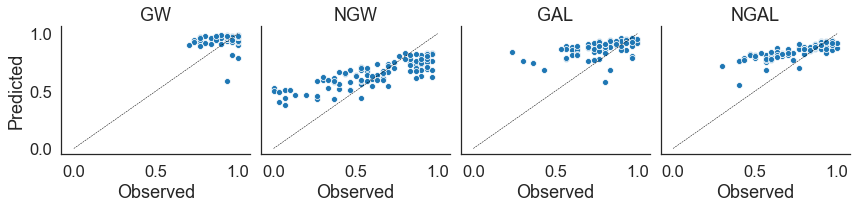

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,3),sharex=True,sharey=True)

## Compute average predicted action.
avg = Y_pred.mean(axis=0)

for i, (ax, title) in enumerate(zip(axes, ['GW','NGW','GAL','NGAL'])):
    
    ## Sort by condition.
    x = Y[0].mean(axis=0)[i::4]
    y = avg[0].mean(axis=0)[i::4]
    
    ## Normalize.
    if i % 2: x = 1-x; y = 1-y
        
    ## Plot.
    sns.scatterplot(x, y, ax=ax)
    ax.plot([0,1],[0,1],lw=0.5,linestyle='--',color='k')
    
    ## Add details.
    ax.set(xlabel='Observed', title=title)
    if not i: ax.set(ylabel='Predicted')
    
sns.despine()
plt.tight_layout()

#### Group Means

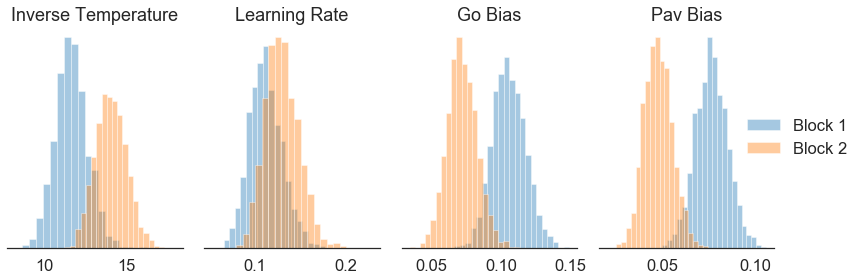

In [13]:
fig, axes = plt.subplots(1,4,figsize=(12,4))
titles = ['Inverse Temperature','Learning Rate','Go Bias','Pav Bias']

for ax, mu, title in zip(axes, [beta_mu, eta_mu, tau_mu, nu_mu], titles):

    sns.distplot(mu[:,0], kde=False, bins=21, label='Block 1', ax=ax)
    sns.distplot(mu[:,1], kde=False, bins=21, label='Block 2', ax=ax)
    ax.set(yticks=[], title=title)
    
ax.legend(loc=7, bbox_to_anchor=(1.5,0.5), frameon=False)
sns.despine(left=True)
plt.tight_layout()

#### Dependability

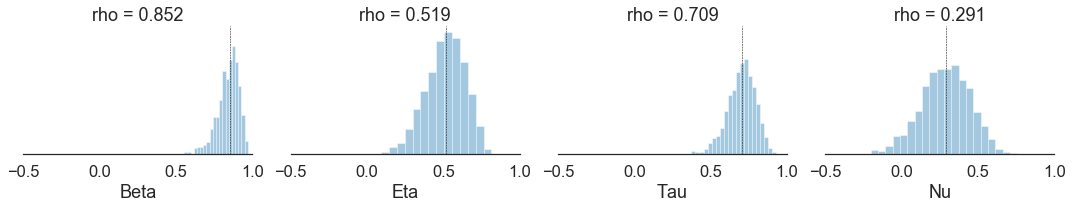

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(15,3),sharex=True,sharey=True)

## Extract dependability parameters.
rho = StanDict['rho']

## Plot dependability.
for ax, arr, title in zip(axes, rho.T, ['Beta','Eta','Tau','Nu']):
    
    ## Plot distribution. 
    sns.distplot(arr, kde=False, bins=21, ax=ax)
    ax.axvline(np.median(arr), lw=0.5, linestyle='--', color='k')
    
    ## Add detail.
    ax.set(xlim=(-0.5,1), xlabel=title, yticks=[], title='rho = %0.3f' %np.median(arr))
    
sns.despine(left=True)
plt.tight_layout()

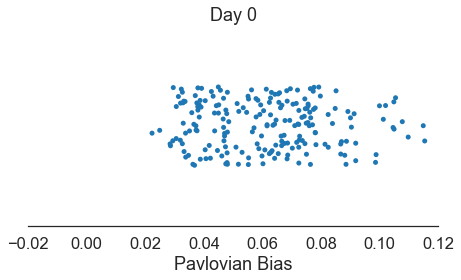

In [7]:
## 
fig, ax = plt.subplots(1,1,figsize=(6,4))

sns.stripplot(np.median(nu, axis=0).flatten(), ax=ax)
ax.set(xlim=(-0.02,0.12), xlabel='Pavlovian Bias', ylim=(-0.25,0.25), title='Day 0')

sns.despine(left=True)
plt.tight_layout()

### Session 2

#### Reconstruct Parameters

In [8]:
from numba import njit

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

@njit
def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal.'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

def diag_pre_multiply(vec, mat):
    return np.diag(vec) @ mat

## Extract parameters.
StanDict = dict()
with h5py.File('stan_results/dependability_m1_t2.hdf5', 'r') as f:
    for k, v in f.items():
        if v.ndim: StanDict[k] = v[:]
        else: StanDict[k] = v[()]
            
## Reconstruct parameter covariance matrix (means).
L_c = StanDict['L_c']
sigma_c_pr = StanDict['sigma_c_pr']
Omega_c = np.array([L @ L.T for L in L_c])
Sigma_c = np.array([diag_pre_multiply( np.exp(sigma), L ) @ diag_pre_multiply( np.exp(sigma), L ).T
                    for sigma, L in zip(sigma_c_pr, L_c)])

## Reconstruct parameter covariance matrix (offsets).
L_d = StanDict['L_d']
sigma_d_pr = StanDict['sigma_d_pr']
Omega_d = np.array([L @ L.T for L in L_d])
Sigma_d = np.array([diag_pre_multiply( np.exp(sigma), L ) @ diag_pre_multiply( np.exp(sigma), L ).T
                    for sigma, L in zip(sigma_d_pr, L_d)])

## Reconstruct subject-level parameters (pre-transform).
theta_c = np.array([Sigma @ theta for Sigma, theta in zip(Sigma_c, StanDict['theta_c_pr'])])
theta_d = np.array([Sigma @ theta for Sigma, theta in zip(Sigma_d, StanDict['theta_d_pr'])])
n_samp, n_par, n_sub = theta_c.shape

## Reconstruct subject-level parameters.
mu_pr = StanDict['mu_pr']

beta = np.zeros((n_samp,2,n_sub))
beta[:,0] = 10 * (mu_pr[:,0,0][:,np.newaxis] + theta_c[:,0] - theta_d[:,0])
beta[:,1] = 10 * (mu_pr[:,0,1][:,np.newaxis] + theta_c[:,0] + theta_d[:,0])
beta_mu = 10 * mu_pr[:,0]

eta = np.zeros((n_samp,2,n_sub))
eta[:,0] = phi_approx(mu_pr[:,1,0][:,np.newaxis] + theta_c[:,1] - theta_d[:,1])
eta[:,1] = phi_approx(mu_pr[:,1,1][:,np.newaxis] + theta_c[:,1] + theta_d[:,1])
eta_mu = phi_approx(mu_pr[:,1])

tau = np.zeros((n_samp,2,n_sub))
tau[:,0] = mu_pr[:,2,0][:,np.newaxis] + theta_c[:,2] - theta_d[:,2]
tau[:,1] = mu_pr[:,2,1][:,np.newaxis] + theta_c[:,2] + theta_d[:,2]
tau_mu = mu_pr[:,2]

nu = np.zeros((n_samp,2,n_sub))
nu[:,0] = mu_pr[:,3,0][:,np.newaxis] + theta_c[:,3] - theta_d[:,3]
nu[:,1] = mu_pr[:,3,1][:,np.newaxis] + theta_c[:,3] + theta_d[:,3]
nu_mu = mu_pr[:,3]

#### Posterior predictive check

In [9]:
np.random.seed(47404)

## Extract metadata.
H = StanDict['H']
T = StanDict['T']
sub_ix = StanDict['sub_ix'] - 1
pav_ix = StanDict['pav_ix']

## Extract data.
Y = StanDict['Y']
R = StanDict['R']

## Preallocate space.
Y_pred = np.zeros((n_samp,*Y.shape))
log_lik = np.zeros_like(Y_pred)

for i in range(2):
    
    ## Preallocate space.
    Q1 = np.ones((n_samp,H)) * pav_ix * 0.5
    Q2 = Q1.copy()
    V  = pav_ix.copy()
    
    for j in range(T):
    
        ## Compute probability of go.
        p = Q1 - Q2 + tau[:,i,sub_ix] + nu[:,i,sub_ix] * V
        p = inv_logit(beta[:,i,sub_ix] * p)

        ## Posterior predictive.
        Y_pred[:,i,j] = np.random.binomial(1,p)
        log_lik[:,i,j] = Y[i,j] * p + (1-p) * (1-Y[i,j])
        
        ## Update action value (go).
        Q1 += Y[i,j] * ( eta[:,i,sub_ix] * ( R[i,j] - Q1 ) )
        
        ## Update action value (no-go).
        Q2 += (1-Y[i,j]) * ( eta[:,i,sub_ix] * ( R[i,j] - Q2 ) )

#### Behavior Check

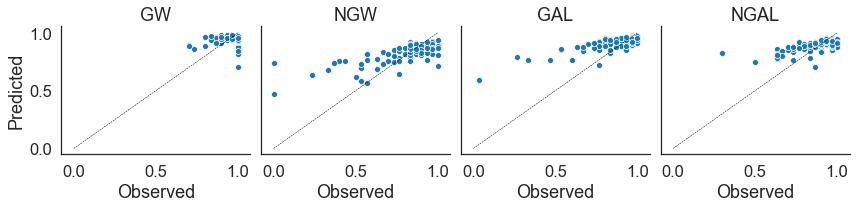

In [10]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,3),sharex=True,sharey=True)

## Compute average predicted action.
avg = Y_pred.mean(axis=0)

for i, (ax, title) in enumerate(zip(axes, ['GW','NGW','GAL','NGAL'])):
    
    ## Sort by condition.
    x = Y[0].mean(axis=0)[i::4]
    y = avg[0].mean(axis=0)[i::4]
    
    ## Normalize.
    if i % 2: x = 1-x; y = 1-y
        
    ## Plot.
    sns.scatterplot(x, y, ax=ax)
    ax.plot([0,1],[0,1],lw=0.5,linestyle='--',color='k')
    
    ## Add details.
    ax.set(xlabel='Observed', title=title)
    if not i: ax.set(ylabel='Predicted')
    
sns.despine()
plt.tight_layout()

#### Group Means

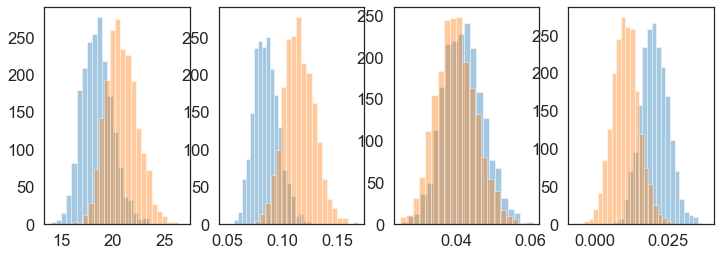

In [11]:
fig, axes = plt.subplots(1,4,figsize=(12,4))

for ax, mu in zip(axes, [beta_mu, eta_mu, tau_mu, nu_mu]):

    sns.distplot(mu[:,0], kde=False, bins=21, ax=ax)
    sns.distplot(mu[:,1], kde=False, bins=21, ax=ax)

#### Dependability

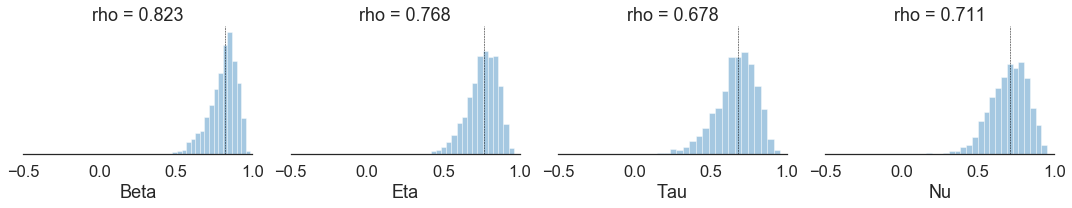

In [12]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(15,3),sharex=True,sharey=True)

## Extract dependability parameters.
rho = StanDict['rho']

## Plot dependability.
for ax, arr, title in zip(axes, rho.T, ['Beta','Eta','Tau','Nu']):
    
    ## Plot distribution. 
    sns.distplot(arr, kde=False, bins=21, ax=ax)
    ax.axvline(np.median(arr), lw=0.5, linestyle='--', color='k')
    
    ## Add detail.
    ax.set(xlim=(-0.5,1), xlabel=title, yticks=[], title='rho = %0.3f' %np.median(arr))
    
sns.despine(left=True)
plt.tight_layout()

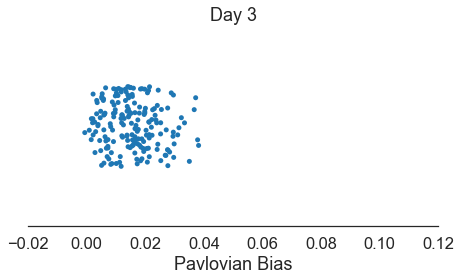

In [13]:
## 
fig, ax = plt.subplots(1,1,figsize=(6,4))

sns.stripplot(np.median(nu, axis=0).flatten(), ax=ax)
ax.set(xlim=(-0.02,0.12), xlabel='Pavlovian Bias', ylim=(-0.25,0.25), title='Day 3')

sns.despine(left=True)
plt.tight_layout()

### Session 3

#### Reconstruct Parameters

In [14]:
from numba import njit

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

@njit
def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal.'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

def diag_pre_multiply(vec, mat):
    return np.diag(vec) @ mat

## Extract parameters.
StanDict = dict()
with h5py.File('stan_results/dependability_m1_t3.hdf5', 'r') as f:
    for k, v in f.items():
        if v.ndim: StanDict[k] = v[:]
        else: StanDict[k] = v[()]
            
## Reconstruct parameter covariance matrix (means).
L_c = StanDict['L_c']
sigma_c_pr = StanDict['sigma_c_pr']
Omega_c = np.array([L @ L.T for L in L_c])
Sigma_c = np.array([diag_pre_multiply( np.exp(sigma), L ) @ diag_pre_multiply( np.exp(sigma), L ).T
                    for sigma, L in zip(sigma_c_pr, L_c)])

## Reconstruct parameter covariance matrix (offsets).
L_d = StanDict['L_d']
sigma_d_pr = StanDict['sigma_d_pr']
Omega_d = np.array([L @ L.T for L in L_d])
Sigma_d = np.array([diag_pre_multiply( np.exp(sigma), L ) @ diag_pre_multiply( np.exp(sigma), L ).T
                    for sigma, L in zip(sigma_d_pr, L_d)])

## Reconstruct subject-level parameters (pre-transform).
theta_c = np.array([Sigma @ theta for Sigma, theta in zip(Sigma_c, StanDict['theta_c_pr'])])
theta_d = np.array([Sigma @ theta for Sigma, theta in zip(Sigma_d, StanDict['theta_d_pr'])])
n_samp, n_par, n_sub = theta_c.shape

## Reconstruct subject-level parameters.
mu_pr = StanDict['mu_pr']

beta = np.zeros((n_samp,2,n_sub))
beta[:,0] = 10 * (mu_pr[:,0,0][:,np.newaxis] + theta_c[:,0] - theta_d[:,0])
beta[:,1] = 10 * (mu_pr[:,0,1][:,np.newaxis] + theta_c[:,0] + theta_d[:,0])
beta_mu = 10 * mu_pr[:,0]

eta = np.zeros((n_samp,2,n_sub))
eta[:,0] = phi_approx(mu_pr[:,1,0][:,np.newaxis] + theta_c[:,1] - theta_d[:,1])
eta[:,1] = phi_approx(mu_pr[:,1,1][:,np.newaxis] + theta_c[:,1] + theta_d[:,1])
eta_mu = phi_approx(mu_pr[:,1])

tau = np.zeros((n_samp,2,n_sub))
tau[:,0] = mu_pr[:,2,0][:,np.newaxis] + theta_c[:,2] - theta_d[:,2]
tau[:,1] = mu_pr[:,2,1][:,np.newaxis] + theta_c[:,2] + theta_d[:,2]
tau_mu = mu_pr[:,2]

nu = np.zeros((n_samp,2,n_sub))
nu[:,0] = mu_pr[:,3,0][:,np.newaxis] + theta_c[:,3] - theta_d[:,3]
nu[:,1] = mu_pr[:,3,1][:,np.newaxis] + theta_c[:,3] + theta_d[:,3]
nu_mu = mu_pr[:,3]

#### Posterior predictive check

In [15]:
np.random.seed(47404)

## Extract metadata.
H = StanDict['H']
T = StanDict['T']
sub_ix = StanDict['sub_ix'] - 1
pav_ix = StanDict['pav_ix']

## Extract data.
Y = StanDict['Y']
R = StanDict['R']

## Preallocate space.
Y_pred = np.zeros((n_samp,*Y.shape))
log_lik = np.zeros_like(Y_pred)

for i in range(2):
    
    ## Preallocate space.
    Q1 = np.ones((n_samp,H)) * pav_ix * 0.5
    Q2 = Q1.copy()
    V  = pav_ix.copy()
    
    for j in range(T):
    
        ## Compute probability of go.
        p = Q1 - Q2 + tau[:,i,sub_ix] + nu[:,i,sub_ix] * V
        p = inv_logit(beta[:,i,sub_ix] * p)

        ## Posterior predictive.
        Y_pred[:,i,j] = np.random.binomial(1,p)
        log_lik[:,i,j] = Y[i,j] * p + (1-p) * (1-Y[i,j])
        
        ## Update action value (go).
        Q1 += Y[i,j] * ( eta[:,i,sub_ix] * ( R[i,j] - Q1 ) )
        
        ## Update action value (no-go).
        Q2 += (1-Y[i,j]) * ( eta[:,i,sub_ix] * ( R[i,j] - Q2 ) )

#### Behavior Check

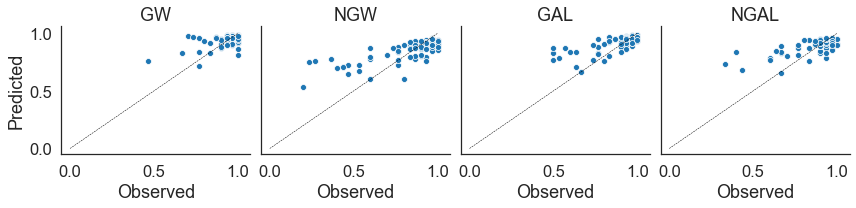

In [16]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,3),sharex=True,sharey=True)

## Compute average predicted action.
avg = Y_pred.mean(axis=0)

for i, (ax, title) in enumerate(zip(axes, ['GW','NGW','GAL','NGAL'])):
    
    ## Sort by condition.
    x = Y[0].mean(axis=0)[i::4]
    y = avg[0].mean(axis=0)[i::4]
    
    ## Normalize.
    if i % 2: x = 1-x; y = 1-y
        
    ## Plot.
    sns.scatterplot(x, y, ax=ax)
    ax.plot([0,1],[0,1],lw=0.5,linestyle='--',color='k')
    
    ## Add details.
    ax.set(xlabel='Observed', title=title)
    if not i: ax.set(ylabel='Predicted')
    
sns.despine()
plt.tight_layout()

#### Group Means

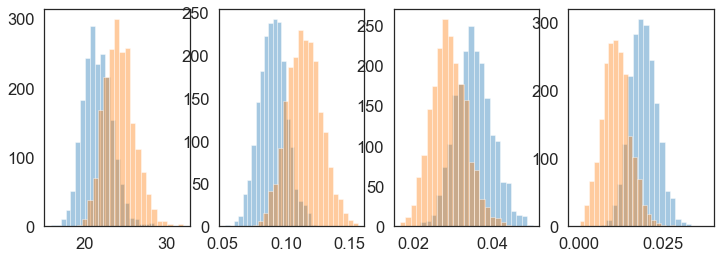

In [17]:
fig, axes = plt.subplots(1,4,figsize=(12,4))

for ax, mu in zip(axes, [beta_mu, eta_mu, tau_mu, nu_mu]):

    sns.distplot(mu[:,0], kde=False, bins=21, ax=ax)
    sns.distplot(mu[:,1], kde=False, bins=21, ax=ax)

#### Dependability

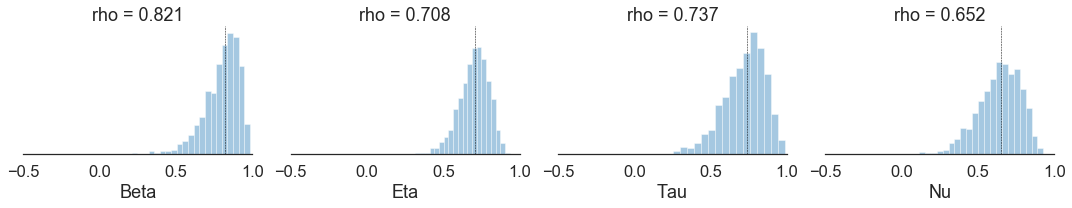

In [18]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(15,3),sharex=True,sharey=True)

## Extract dependability parameters.
rho = StanDict['rho']

## Plot dependability.
for ax, arr, title in zip(axes, rho.T, ['Beta','Eta','Tau','Nu']):
    
    ## Plot distribution. 
    sns.distplot(arr, kde=False, bins=21, ax=ax)
    ax.axvline(np.median(arr), lw=0.5, linestyle='--', color='k')
    
    ## Add detail.
    ax.set(xlim=(-0.5,1), xlabel=title, yticks=[], title='rho = %0.3f' %np.median(arr))
    
sns.despine(left=True)
plt.tight_layout()

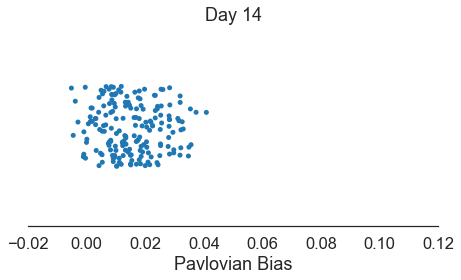

In [19]:
## 
fig, ax = plt.subplots(1,1,figsize=(6,4))

sns.stripplot(np.median(nu, axis=0).flatten(), ax=ax)
ax.set(xlim=(-0.02,0.12), xlabel='Pavlovian Bias', ylim=(-0.25,0.25), title='Day 14')

sns.despine(left=True)
plt.tight_layout()

## Section 2: Reliability

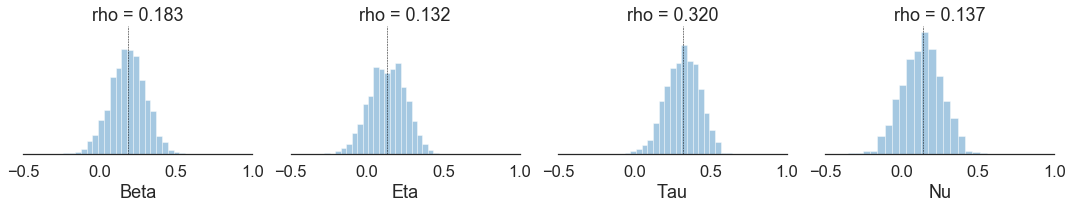

In [20]:
## Extract parameters.
StanDict = dict()
with h5py.File('stan_results/reliability_t3.hdf5', 'r') as f:
    for k, v in f.items():
        if v.ndim: StanDict[k] = v[:]
        else: StanDict[k] = v[()]

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(15,3),sharex=True,sharey=True)

## Extract dependability parameters.
rho = StanDict['rho']

## Plot dependability.
for ax, arr, title in zip(axes, rho.T, ['Beta','Eta','Tau','Nu']):
    
    ## Plot distribution. 
    sns.distplot(arr, kde=False, bins=21, ax=ax)
    ax.axvline(np.median(arr), lw=0.5, linestyle='--', color='k')
    
    ## Add detail.
    ax.set(xlim=(-0.5,1), xlabel=title, yticks=[], title='rho = %0.3f' %np.median(arr))
    
sns.despine(left=True)
plt.tight_layout()